# DM Etude thermique

- author : Sylvie Dagoret-Campagne
- afflilation : LAL/IJCLab, CNRS
- creation date : Mars 14th 2021
- update : 
 

## Table des constantes de astropy
https://docs.astropy.org/en/stable/constants/

In [1]:
from astropy import constants as const

In [2]:
from astropy.constants import m_e,c,eps0,e,R_sun

In [3]:
from astropy import units as u

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import numpy as np
import re
import time
from datetime import datetime,date,timedelta
import dateutil.parser
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.coordinates import Angle
from astropy import units as u

In [6]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.colors as colors
import matplotlib.cm as cmx

In [7]:
matplotlib.rcParams.update({'font.size': 15, 'lines.linewidth': 2, 'lines.markersize': 15})
matplotlib.rcParams["axes.labelsize"]="small"
matplotlib.rcParams["axes.linewidth"]=2.0
matplotlib.rcParams["xtick.major.size"]=8
matplotlib.rcParams["ytick.major.size"]=8
matplotlib.rcParams["ytick.minor.size"]=5
matplotlib.rcParams["xtick.labelsize"]="large"
matplotlib.rcParams["ytick.labelsize"]="large"
matplotlib.rcParams["figure.figsize"]=(8,4)
matplotlib.rcParams['axes.titlesize'] = 15
matplotlib.rcParams['axes.titleweight'] = 'bold'
#matplotlib.rcParams['axes.facecolor'] = 'blue'
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
matplotlib.rcParams['lines.markersize'] = 10  # markersize, in points
matplotlib.rcParams['grid.alpha'] = 1. # transparency, between 0.0 and 1.0
matplotlib.rcParams['grid.linestyle'] = '-' # simple line
matplotlib.rcParams['grid.linewidth'] = 0.4 # in points 

In [8]:
from scipy import signal

In [9]:
from dateutil.relativedelta import relativedelta

In [10]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

# Preambule

## Question 1.1 : Modélisation de la pièce

In [11]:
a = 8.0 # Longueur en m
b = 5.  # largeur en m
h = 2.5 # hauteur en m

In [12]:
Cv_air = 1.25e3 # J/m3/K : capacité thermique volumique de l'air

In [13]:
P = 2000. # W : puissance du radiateur 

### Question 1.1.a : capacité thermique de la piece 

In [14]:
C = Cv_air*a*b*h # capacité thermique de la pièce
C  # J/K

125000.0

### Question 1.1.b : Bilan thermique 

$$
P = C \frac{dT}{dt}
$$

d'où

$$
T = T_0 + \frac{P}{C}(t-t_0)
$$

### Question 1.1.c : Durée

In [15]:
T_i = 10 # degres
T_f = 20 # degres
Delta_T = T_f  - T_i

In [16]:
t= Delta_T*C/P

In [17]:
t # temps en secondes pour passer de 10 à 20°

625.0

$$
\Delta t = 10 min 25 secondes
$$

## Influence des murs

### Paramètres du mur

In [18]:
L=0.15 # m : epaisseur des murs

In [19]:
c_mur= 1e3 # J kg-1 K-1 : capacité thermique massique du mur

In [20]:
rho_mur= 2.2e3 # kg/m3 : densité du mur

In [21]:
cond_th_mur=1.5 # W/m/K : conductivité thermique du mur 

### Question 1.2.a : Surface des murs

In [22]:
S_p=2*(h)*(a+b)
S_p # m2 : surface des murs

65.0

### Question 1.2.b : Volume des murs et capacité thermique des murs

$$
V_b = S_p L
$$

et

$$
C_{mur} = \rho S_p L c_{mur}
$$

In [23]:
Vb=S_p*L
Vb  #  m3 : volume de béton des murs

9.75

In [24]:
M_mur=Vb*rho_mur # kg : masse totale du mur 

In [25]:
C_mur = c_mur*M_mur  # Capacité thermique des mur
C_mur  #  J/K

21450000.0

In [26]:
C # capacité calorifique de la pièce

125000.0

In [27]:
C_mur/C

171.6

La capacité calorifique du mur est 172 fois plus grande que celle de l'air de la pièce. Les murs sont capable
de stocker plus facilement de la chaleur que l'air.

Comme $\frac{\Delta T}{dt}= \frac{P}{C}$, il est plus facile (rapide) d'augmenter la température de l'air que celle du mur.

# Première partie : équation de la chaleur

## Généralités

### Question 1.3.a : Loi de Fourier

$$
\frac{dQ}{dt} = - S \lambda  \nabla  T
$$

- $\lambda$ : conductivité thermique en W/m/K

### Question 1.3.b : Equation différentielle

- Différence entre flux entrant et sortant

$$
Q(x) = - \lambda \frac{dT}{dx}(x)S \Delta t \\
Q(x+dx) = - \lambda \frac{dT}{dx}(x+dx)S \Delta t \\
\Delta Q = - \lambda S \Delta t \frac{d^2 T}{dx^2}(x)
$$

- Stockage d'énergie dans l'élément de mur d'épaisseur $dx$ et de masse :

$$
dM = \rho S dx \\
$$

- chaleur emmagasinée par le mur
$$
dQ_{abs} = - c_{mur} \rho dx dT
$$

$$
\Delta Q = dQ_{abs}
$$

L'équation différentielle est:
$$
\lambda \frac{d^2 T}{dx^2} - \rho c_{mur} \frac{dT}{dt} =0
$$

## Etude du régime stationnaire : 1.4

In [28]:
Tint=20
Text=10
DT=Tint-Text

### Question 1.4.a : définition du régime stationnaire

$$
\frac{dT}{dt} = 0
$$

### Question 1.4.b : Résoudre l'équation en régime stationnaire:

$$
T(x) = T_{int} + \frac{x}{L}(T_{ext}-T_{int})
$$

In [29]:
def T(x):
    """
    """ 
    y=np.where(x<0,0,x)
    z=np.where(x>L,L,y)
    
    
    Tx= Tint - x/L*DT
    return Tx

Text(0, 0.5, 'T(x) (m)')

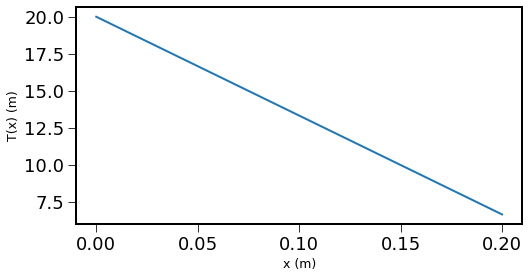

In [30]:
x=np.linspace(0,0.20,100)
plt.plot(x,T(x))
plt.xlabel("x (m)")
plt.ylabel("T(x) (m)")

### Question 1.4.c : Température moyenne

$$
T_{moy} = \frac{1}{L} \int_{x=0}^{x=L} T(x) dx
$$

$$
T_{moy} = \frac{T_{int}+T_{ext}}{2}
$$

$$
x_p = \frac{L}{2}
$$

### Question 1.4.d : Flux qui traverse le mur

$$
j = - \lambda \nabla T = - \frac{\lambda}{L}(T_{ext}-T_{int})
$$

- Le flux est indépendant de $x$

### Question 1.4.e : Puissance du radiateur pour maintenir une température de 20 degrés dans la pièce

$$
P = \frac{dQ}{dt} = j \cdot S = \frac{\lambda S}{L}(T_{ext}-T_{int})
$$

In [31]:
P=S_p*cond_th_mur/L*DT
P  # en W

6500.0

## Résistance thermique

### Question 1.5.a

- Loi d'Ohm
$$
j = \sigma E
$$

### Question 1.5.b : Résistance thermique du mur

$$
R_{th} = \frac{1}{\lambda} \frac{L}{S}
$$

In [32]:
Rth_mur= 1/cond_th_mur*L/S_p
Rth_mur # résistance thermique du mur en K/W

0.0015384615384615382

# Deuxième partie : modélisation électrique

## Circuit électrique : 1.6

### Question 1.6.b circuit en régime permanent continu

- équation électrique
$$
U = (R_1+R_2) i
$$

- equation thermique
$$
P_{th} = \frac{T_{int}-T_{ext}}{R_{th 1}+ R_{th2}}
$$

In [33]:
Rth1=Rth_mur/2
Rth2=Rth_mur/2

In [34]:
Rth1 # K/W

0.0007692307692307691

## Etablissement de l'expression de l'impédance : 1.7

###  Question 1.7.a

$$
Z_2 = \frac{R_2}{1+j R_2 C_2 \omega}
$$

### Question 1.7.b 

$$
Z_1 = R_1 + Z_2
$$

### Question 1.7.c

$$
Z_1 = R_1 + \frac{R_2}{1+j R_2 C_2 \omega} = \frac{(R_1+R_2)+j R_1 R_2 C_2 \omega}{1+j R_2 C_2 \omega} \\
Y_1 = \frac{1+j R_2 C_2 \omega}{(R_1+R_2)+j R_1 R_2 C_2 \omega}
$$

$$
Y_{tot} = j C_1 \omega + Y_1 = j C_1 \omega + \frac{1+j R_2 C_2 \omega}{(R_1+R_2)+j R_1 R_2 C_2 \omega}
$$

### Question 1.7.d

$$
\frac{U_1}{I_0} = \frac{1 + j \frac{R_1 R_2}{R_1+R_2}C_2 \omega}{1 + j\left((R_1+R_2)C_1 +R_2C_2\right)\omega -R_1R_2C_1C_2 \omega^2}(R_1+R_2)
$$

## Exploitation

### Question 1.8.a

$$
\lim_{\omega \rightarrow 0} \frac{U_1}{I_0} = (R_1+R_2) 
$$

### Question 1.8.b

$$
\lim_{\omega \rightarrow \infty} \frac{U_1}{I_0} = \frac{1}{jC_1 \omega} 
$$

### Question 1.8.c

- **C'est un filtre passe bas du 1er ordre**

### Question 1.8.d

$$
\frac{U_1}{I_0} = R \frac{1 + j \frac{\alpha}{4} RC \omega}{1 + j RC (1+ \frac{\alpha}{2})\omega - \frac{\alpha}{4}(RC)^2 \omega^2}
$$

On pose:
$
\omega_0 = \frac{2}{\sqrt{\alpha} RC} \\
\omega_1 = \frac{4}{\alpha RC} \\
Q = 2 \frac{1 + \frac{\alpha}{2}}{\sqrt{\alpha}}
$

$$
\frac{U_1}{I_0} = R \frac{1+j \frac{\omega}{\omega_1}}{1 + j Q \frac{\omega}{\omega_0} + \left( \frac{\omega}{\omega_0}\right)^2}
$$

- Notons que : 
$
\frac{\omega_1}{\omega_0} = \frac{2}{\sqrt{\alpha}}
$

et donc pour $\alpha$ grand, $\omega_1 \ll \omega_0$

- Notons que $Q >> 2 $ pour $\alpha$ grand, $\omega_1 \ll \omega_0$, le régime est donc très atténué

In [35]:
alpha = 200
RC= Rth_mur * C_mur
RC

32999.99999999999

### Diagrame de Bode calculé par moi (faux) 

In [36]:
def H(x):
    """
    Fonction de transfert (complexe)
    """
    y = (1+1j/4*alpha*x)/(1 + 1j*RC*x*(1+alpha/2)-alpha/4*RC**2*x**2)
    return y

In [37]:
def Mod(x):
    """
    Module de la fonction de transfert
    """
    return np.abs(H(x))

In [38]:
def Arg(x):
    """
    Argument de la fonction de transfert
    """
    
    realpart = np.real(H(x))
    imagpart = np.imag(H(x))
    
    #angle = np.where(realpart > 0, np.angle(H(x)),  np.angle(H(x)) )
    
    angle = np.angle(H(x))
    
    return angle

In [39]:
# Valeur des Omega en rad/s
X = np.logspace(-8,-2,1000,base=10)

In [40]:
# Module du Gain
G = Mod(X)

In [41]:
# Phase du Gain
Phi= Arg(X)*180./np.pi

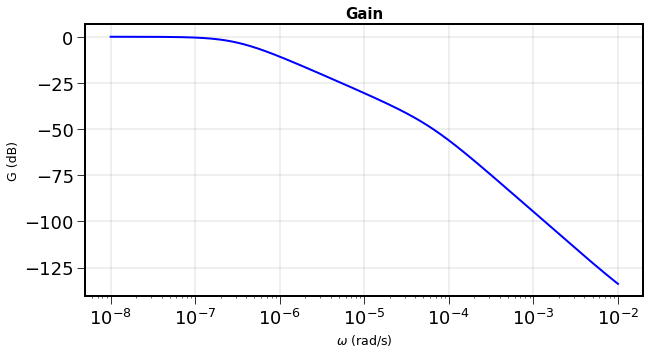

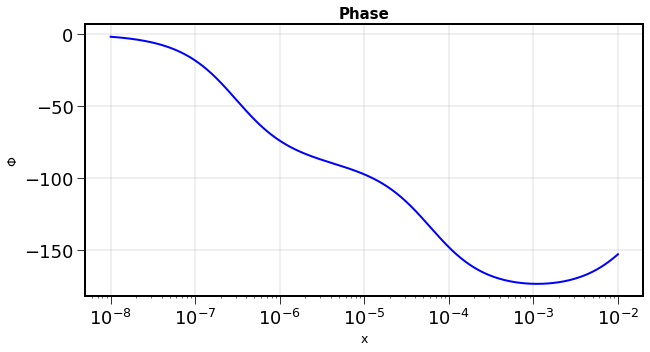

In [42]:
# Gain
plt.figure(figsize=(10,5))
#plt.loglog(X,G,"b-")
plt.plot(X,20*np.log10(G),"b-")
plt.grid()
plt.xlabel("$\omega$ (rad/s)")
plt.ylabel("G (dB)")
plt.title("Gain")
plt.xscale("log")
plt.show()

# Phase
plt.figure(figsize=(10,5))
plt.semilogx(X,Phi,"b-")
plt.grid()
plt.xlabel("x")
plt.ylabel("$\\Phi$")
plt.title("Phase")
plt.show()

### Diagramme de Bode calculé par scipy.signal (juste)

In [43]:
omega_0= 2/np.sqrt(alpha)/RC
omega_1= 4/alpha/RC
Q= 2*(1+alpha/2)/np.sqrt(alpha)

In [44]:
# numérateur de la fonction de la transformée de Laplace (bp +c) [b,c]
num = [ 1./omega_1 , 1. ]
num

[1649999.9999999995, 1.0]

In [45]:
# dénominateur de la fonction de la transformée de Laplace (ap2 +bp +c) [a,b,c]
den = [1./omega_0**2, Q/omega_0,  1.]
den

[54449999999.999985, 3332999.9999999995, 1.0]

In [46]:
s1 = signal.lti(num,den)
w, mag, phase = signal.bode(s1,w=X)

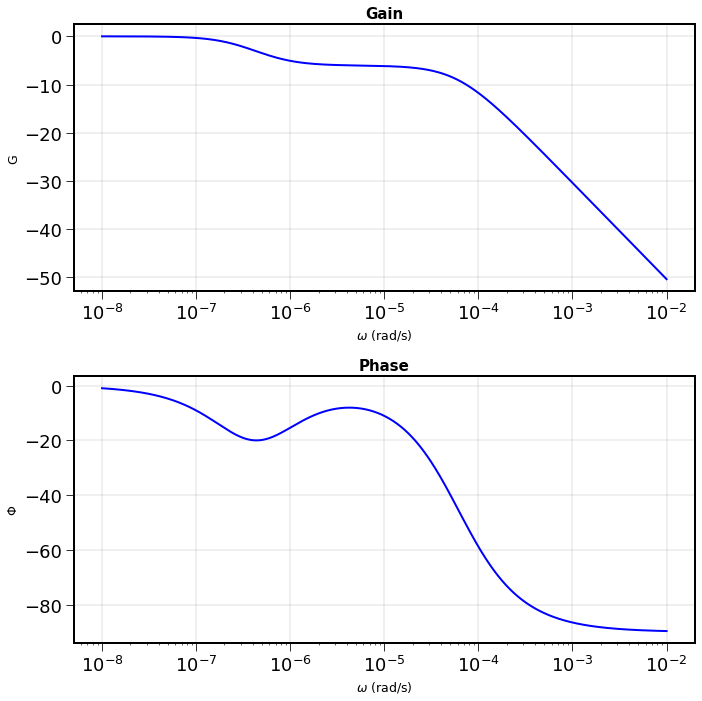

In [47]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.semilogx(w, mag,"b")    # Bode magnitude plot
plt.grid()
plt.xlabel("$\omega$ (rad/s)")
plt.ylabel("G")
plt.title("Gain")


plt.subplot(2,1,2)
plt.semilogx(w, phase,"b")  # Bode phase plot
plt.grid()
plt.xlabel("$\omega$ (rad/s)")
plt.ylabel("$\\Phi$")
plt.title("Phase")

plt.tight_layout()
plt.show()

On voit mieux avec la phase quand $\omega_1$ provoque la remontée de la phase

# Troisieme partie : Isolation

In [48]:
e=0.05
cond_th_is=0.05

In [49]:
Rth_is=1/cond_th_is*e/S_p
Rth_is

0.015384615384615385

In [50]:
Rth_mur

0.0015384615384615382

In [51]:
P=Delta_T/(Rth_mur+Rth_is)
P

590.9090909090909

##### 600 W, on gagne un facteur 10 de la puissance consomée